# Cognitive Stress Detection from Wearable Physiological Signals

**Goal**: Build a classifier to detect cognitive stress vs rest states using physiological data from wearable devices.

## Dataset Overview:
- **22 subjects** (10 males V1 protocol, 12 females V2 protocol)
- **Signals**: EDA, BVP, HR, IBI (for HRV), Temperature, Accelerometer
- **Cognitive Tasks**: Stroop test, TMCT, Opinion speeches, Subtraction test
- **Rest Periods**: Baseline, rest between tasks

## Stress Induction Protocol

### First version (S01 to S18)

![Stress illustration](/Users/camilletran/Documents/Capstone/behavior-cap/Capstone-Behavorial/stress_v1.png)

### Second version (f01 to f18)

![Stress illustration](/Users/camilletran/Documents/Capstone/behavior-cap/Capstone-Behavorial/stress_v2.png)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from scipy import stats

In [4]:
dataset_path = '22subjects/STRESS'
stress_level_v1_path = 'Stress_Level_v1.csv'
stress_level_v2_path = 'Stress_Level_v2.csv'
subject_info_path = 'subject-info.csv'

##  Define Helper Functions from Wearable_Dataset.ipynb

The functions help us read and process the physiological data files.

In [5]:
def create_df_array(dataframe):
    """Converts a pandas DataFrame to a flattened numpy array."""
    return dataframe.values.flatten()


def time_abs_(UTC_array):
    """Converts UTC timestamps to seconds from the start of recording."""
    new_array = []
    start_time = datetime.datetime.strptime(UTC_array[0], '%Y-%m-%d %H:%M:%S')
    
    for utc in UTC_array:
        current_time = datetime.datetime.strptime(utc, '%Y-%m-%d %H:%M:%S')
        seconds_elapsed = (current_time - start_time).total_seconds()
        new_array.append(int(seconds_elapsed))
    
    return new_array


def moving_average(acc_data):
    """
    Applies a moving average filter to accelerometer data to measure movement.
    Higher values = more movement, Lower values = less movement
    """
    avg = 0
    prevX, prevY, prevZ = 0, 0, 0
    results = []
    
    # Process every second (32 samples at 32 Hz)
    for i in range(0, len(acc_data), 32):
        sum_ = 0
        buffX = acc_data[i:i+32, 0]
        buffY = acc_data[i:i+32, 1]
        buffZ = acc_data[i:i+32, 2]
        
        for j in range(len(buffX)):
            sum_ += max(
                abs(buffX[j] - prevX),
                abs(buffY[j] - prevY),
                abs(buffZ[j] - prevZ)
            )
            prevX, prevY, prevZ = buffX[j], buffY[j], buffZ[j]
        
        avg = avg * 0.9 + (sum_ / 32) * 0.1
        results.append(avg)
    
    return results

print("Helper functions defined")

Helper functions defined


## Load Physiological Signals
Reads physiological signals from all subject folders, adapted from wearables_dataset.ipynb

read_signals(main_folder)
    Returns 3 dictionaries:
    
    signal_dict: Raw signal values          -> signal_data['S05']['EDA']    # EDA values for subject S05
    time_dict: Time arrays for each signal  -> time_data['S05']['EDA']      # Time array
    fs_dict: Sampling frequencies           -> fs_dict['S05']['EDA']        # 4 (Hz)


In [6]:
def read_signals(main_folder):
    """
    Each subject folder contains: EDA, BVP, HR, IBI, TEMP, ACC, tags
    """
    signal_dict = {}
    time_dict = {}
    fs_dict = {}
    
    subfolders = next(os.walk(main_folder))[1]
    
    # Get start times
    utc_start_dict = {}
    for folder_name in subfolders:
        csv_path = f'{main_folder}/{folder_name}/EDA.csv'
        df = pd.read_csv(csv_path)
        utc_start_dict[folder_name] = df.columns.tolist()
    
    # Read all signals
    for folder_name in subfolders:
        folder_path = os.path.join(main_folder, folder_name)
        files = os.listdir(folder_path)
        
        signals = {}
        time_line = {}
        fs_signal = {}
        
        desired_files = ['EDA.csv', 'BVP.csv', 'HR.csv', 'TEMP.csv', 'tags.csv', 'ACC.csv', 'IBI.csv']
        
        for file_name in files:
            if file_name not in desired_files:
                continue
            
            file_path = os.path.join(folder_path, file_name)
            signal_name = file_name.replace('.csv', '')
            
            if file_name == 'tags.csv':
                try:
                    df = pd.read_csv(file_path, header=None)
                    tags_vector = create_df_array(df)
                    tags_UTC_vector = np.insert(tags_vector, 0, utc_start_dict[folder_name])
                    signal_array = time_abs_(tags_UTC_vector)
                except pd.errors.EmptyDataError:
                    signal_array = []
            
            elif file_name == 'IBI.csv':
                df = pd.read_csv(file_path)
                signal_array = df.values
                fs_signal['IBI'] = 'variable'
            
            else:
                df = pd.read_csv(file_path)
                fs = int(df.iloc[0, 0])
                signal_array = df.iloc[1:].values
                time_array = np.linspace(0, len(signal_array)/fs, len(signal_array))
                
                time_line[signal_name] = time_array
                fs_signal[signal_name] = fs
            
            signals[signal_name] = signal_array
        
        signal_dict[folder_name] = signals
        time_dict[folder_name] = time_line
        fs_dict[folder_name] = fs_signal
    
    return signal_dict, time_dict, fs_dict

print(" Data loading function defined")

 Data loading function defined


In [7]:
# Load all physiological signals
print("Loading physiological signals...")
signal_data, time_data, fs_dict = read_signals(dataset_path)

subjects = list(signal_data.keys())
v1_subjects = sorted([s for s in subjects if s.startswith('S')])
v2_subjects = sorted([s for s in subjects if s.startswith('f')])

print(f"\n✓ Loaded {len(subjects)} subjects:")
print(f"   V1: {v1_subjects}")
print(f"   V2: {v2_subjects}")

Loading physiological signals...

✓ Loaded 22 subjects:
   V1: ['S04', 'S05', 'S08', 'S09', 'S10', 'S13', 'S14', 'S15', 'S17', 'S18']
   V2: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13']


## Load Self-Reported Stress Levels

In [8]:
stress_level_v1 = pd.read_csv(stress_level_v1_path, index_col=0)
stress_level_v2 = pd.read_csv(stress_level_v2_path, index_col=0)
subject_info = pd.read_csv(subject_info_path, index_col=0)
print("Self-reported stress levels loaded")

Self-reported stress levels loaded


In [9]:
print(f"\nV1 Phases: {list(stress_level_v1.columns)}")
print("\nstress levels V1: (Male subjects only)")
stress_level_v1


V1 Phases: ['Baseline', 'Stroop', 'First Rest', 'TMCT', 'Second Rest', 'Real Opinion', 'Opposite Opinion', 'Subtract']

stress levels V1: (Male subjects only)


,Baseline,Stroop,First Rest,TMCT,Second Rest,Real Opinion,Opposite Opinion,Subtract
S01,3.0,4.5,4.0,4.0,5.5,6.0,7.0,7.0
S02,2.0,4.0,2.0,2.0,2.0,4.0,5.0,4.0
S03,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0
S04,3.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0
S05,1.0,2.0,1.0,4.0,1.0,2.0,2.0,3.0
S06,2.0,3.0,2.0,5.0,3.0,3.0,3.0,5.0
S07,5.0,6.0,6.0,8.0,7.0,8.0,9.0,9.0
S08,0.0,1.0,1.0,5.5,1.5,0.5,0.5,1.5
S09,7.0,5.0,3.0,5.0,4.0,7.0,6.0,5.0
S10,4.0,4.0,4.0,6.0,5.0,5.0,5.0,5.0


In [10]:
print(f"V2 Phases: {list(stress_level_v2.columns)}")
print("\nstress levels V2: (Female subjects only)")
stress_level_v2

V2 Phases: ['Baseline', 'TMCT', 'First Rest', 'Real Opinion', 'Opposite Opinion', 'Second Rest', 'Subtract']

stress levels V2: (Female subjects only)


,Baseline,TMCT,First Rest,Real Opinion,Opposite Opinion,Second Rest,Subtract
f01,2.0,5.0,2.0,3.0,4.0,2.0,3.0
f02,3.0,5.0,1.0,2.0,3.0,2.0,3.0
f03,5.0,8.0,1.0,3.0,5.0,1.0,6.0
f04,2.0,4.0,3.0,3.0,4.0,1.0,4.0
f05,3.0,4.0,3.0,3.0,3.0,2.0,3.0
f06,3.0,4.0,1.0,2.0,3.0,1.0,3.0
f07,1.0,4.0,1.0,3.0,1.0,1.0,3.0
f08,0.0,3.0,1.0,1.0,1.0,1.0,2.0
f09,5.0,6.0,3.0,4.0,4.0,3.0,5.0
f10,6.0,8.0,5.0,5.0,5.0,4.0,5.0


---
### Visualize Self-Reported Stress Patterns

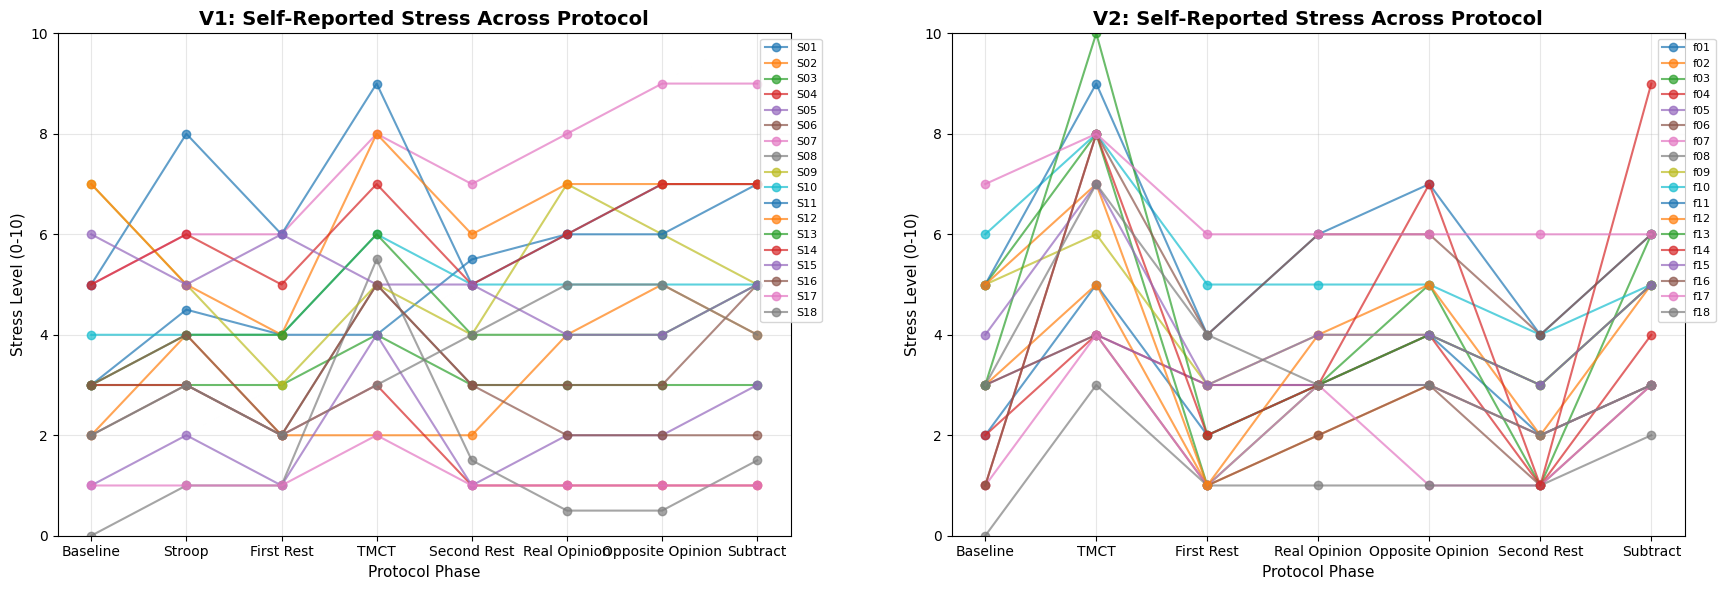

In [11]:
# Plot stress progression for all subjects
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# V1 subjects (with Stroop test)
for subject, row in stress_level_v1.iterrows():
    axes[0].plot(row.index, row.values, marker='o', alpha=0.7, label=subject)
axes[0].set_title('V1: Self-Reported Stress Across Protocol', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Protocol Phase', fontsize=11)
axes[0].set_ylabel('Stress Level (0-10)', fontsize=11)
axes[0].legend(bbox_to_anchor=(1.05, 1), fontsize=8)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 10)

# V2 subjects (no Stroop test)
for subject, row in stress_level_v2.iterrows():
    axes[1].plot(row.index, row.values, marker='o', alpha=0.7, label=subject)
axes[1].set_title('V2: Self-Reported Stress Across Protocol', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Protocol Phase', fontsize=11)
axes[1].set_ylabel('Stress Level (0-10)', fontsize=11)
axes[1].legend(bbox_to_anchor=(1.05, 1), fontsize=8)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

# Which tasks induce the most stress?

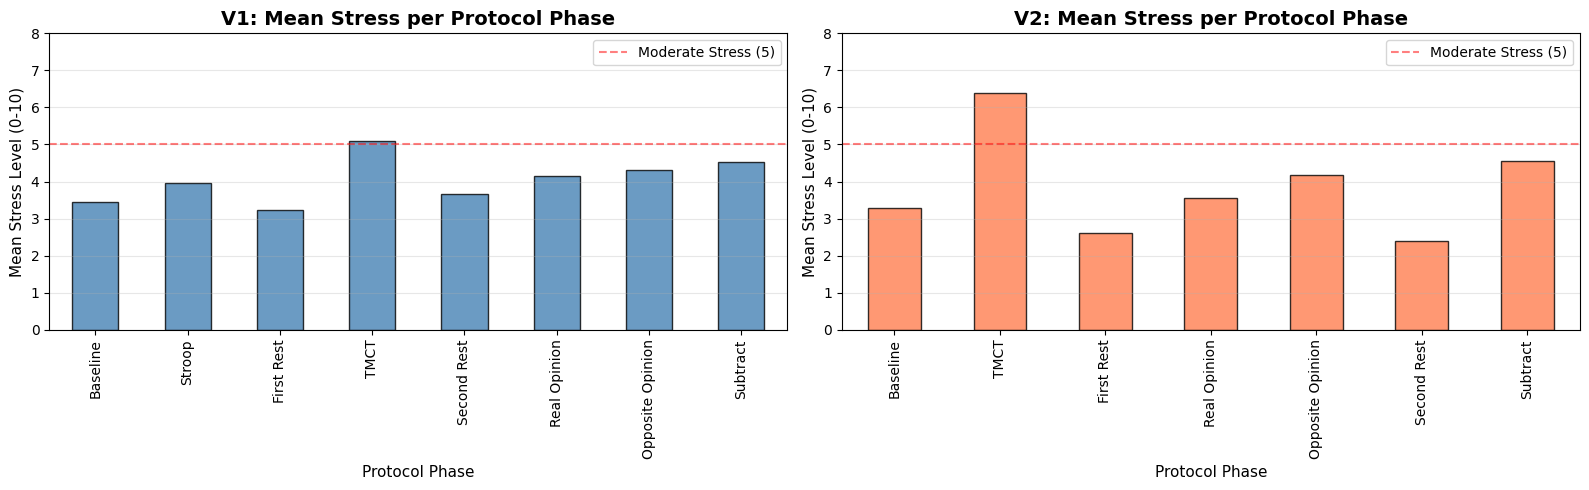

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# V1 mean stress per phase
mean_v1 = stress_level_v1.mean()
mean_v1.plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.8, edgecolor='black')
axes[0].set_title('V1: Mean Stress per Protocol Phase', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Mean Stress Level (0-10)', fontsize=11)
axes[0].set_xlabel('Protocol Phase', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 8)
axes[0].axhline(y=5, color='red', linestyle='--', alpha=0.5, label='Moderate Stress (5)')
axes[0].legend()

# V2 mean stress per phase
mean_v2 = stress_level_v2.mean()
mean_v2.plot(kind='bar', ax=axes[1], color='coral', alpha=0.8, edgecolor='black')
axes[1].set_title('V2: Mean Stress per Protocol Phase', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Mean Stress Level (0-10)', fontsize=11)
axes[1].set_xlabel('Protocol Phase', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim(0, 8)
axes[1].axhline(y=5, color='red', linestyle='--', alpha=0.5, label='Moderate Stress (5)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [13]:
print("\nV1 Protocol:")
for phase, stress in mean_v1.sort_values(ascending=False).items():
    print(f"  {phase:25s}: {stress:.2f}")
print("\nV2 Protocol:")
for phase, stress in mean_v2.sort_values(ascending=False).items():
    print(f"  {phase:25s}: {stress:.2f}")


V1 Protocol:
  TMCT                     : 5.08
  Subtract                 : 4.53
  Opposite Opinion         : 4.31
  Real Opinion             : 4.14
  Stroop                   : 3.97
  Second Rest              : 3.67
  Baseline                 : 3.44
  First Rest               : 3.22

V2 Protocol:
  TMCT                     : 6.39
  Subtract                 : 4.56
  Opposite Opinion         : 4.17
  Real Opinion             : 3.56
  Baseline                 : 3.28
  First Rest               : 2.61
  Second Rest              : 2.39


---
### Visualize Physiological Raw Signals

##### Segmentation 
get_stress_rest_segments(subject_id, tags)
- Divides protocol into STRESS vs REST periods
- Uses tag timestamps to identify phases

In [14]:
#Creates time segments labeled as STRESS or REST based on protocol tags.
def get_stress_rest_segments(subject_id, tags):
    """
    V1: Baseline(R) → Stroop(S) → Rest(R) → TMCT(S) → Rest(R) → Speeches(S) → Subtract(S)
    V2: Baseline(R) → TMCT(S) → Rest(R) → Speeches(S) → Rest(R) → Subtract(S)
    """
    segments = []
    
    if subject_id.startswith('S'):  # V1 protocol
        if len(tags) >= 13:
            segments.append({'start': tags[0], 'end': tags[3], 'label': 'REST', 'phase': 'Baseline'})
            segments.append({'start': tags[3], 'end': tags[4], 'label': 'STRESS', 'phase': 'Stroop'})
            segments.append({'start': tags[4], 'end': tags[5], 'label': 'REST', 'phase': 'First Rest'})
            segments.append({'start': tags[5], 'end': tags[6], 'label': 'STRESS', 'phase': 'TMCT'})
            segments.append({'start': tags[6], 'end': tags[7], 'label': 'REST', 'phase': 'Second Rest'})
            segments.append({'start': tags[7], 'end': tags[8], 'label': 'STRESS', 'phase': 'Real Opinion'})
            segments.append({'start': tags[8], 'end': tags[9], 'label': 'REST', 'phase': 'Transition Rest 1'})  # NEW!
            segments.append({'start': tags[9], 'end': tags[10], 'label': 'STRESS', 'phase': 'Opposite Opinion'})
            segments.append({'start': tags[10], 'end': tags[11], 'label': 'REST', 'phase': 'Transition Rest 2'})  # NEW!
            segments.append({'start': tags[11], 'end': tags[12], 'label': 'STRESS', 'phase': 'Subtract'})
    
    else:  # V2 protocol
        if len(tags) >= 10:
            segments.append({'start': tags[0], 'end': tags[2], 'label': 'REST', 'phase': 'Baseline'})
            segments.append({'start': tags[2], 'end': tags[3], 'label': 'STRESS', 'phase': 'TMCT'})
            segments.append({'start': tags[3], 'end': tags[4], 'label': 'REST', 'phase': 'First Rest'})
            segments.append({'start': tags[4], 'end': tags[5], 'label': 'STRESS', 'phase': 'Real Opinion'})
            segments.append({'start': tags[5], 'end': tags[6], 'label': 'REST', 'phase': 'Transition Rest'})  # NEW!
            segments.append({'start': tags[6], 'end': tags[7], 'label': 'STRESS', 'phase': 'Opposite Opinion'})
            segments.append({'start': tags[7], 'end': tags[8], 'label': 'REST', 'phase': 'Second Rest'})
            segments.append({'start': tags[8], 'end': tags[9], 'label': 'STRESS', 'phase': 'Subtract'})
    
    return segments

print("Segmentation function defined")

Segmentation function defined


In [15]:
# Create segments for all subjects
all_segments = {}
for subject in subjects:
    tags = signal_data[subject]['tags']
    if len(tags) > 0:
        segments = get_stress_rest_segments(subject, tags)
        all_segments[subject] = segments

print(f"Created segments for {len(all_segments)} subjects\n")
print(f"Ex: - {subjects[0]}:")
for seg in all_segments[subjects[0]]:
    dur = seg['end'] - seg['start']
    print(f"  {seg['label']:7s} {seg['phase']:20s} {seg['start']:4d}-{seg['end']:4d}s ({dur}s)")

Created segments for 22 subjects

Ex: - S05:
  REST    Baseline                0- 478s (478s)
  STRESS  Stroop                478- 590s (112s)
  REST    First Rest            590- 926s (336s)
  STRESS  TMCT                  926-1095s (169s)
  REST    Second Rest          1095-1322s (227s)
  STRESS  Real Opinion         1322-1356s (34s)
  REST    Transition Rest 1    1356-1417s (61s)
  STRESS  Opposite Opinion     1417-1448s (31s)
  REST    Transition Rest 2    1448-1493s (45s)
  STRESS  Subtract             1493-1525s (32s)


---
### Visualize Raw Signals

In [16]:
#Plotting function to visualize all physiological signals for one subject.
def plot_subject_signals(subject_id, signals, time_dict, tags, state='STRESS'):
    """
    Plot all physiological signals for one subject.
    Highlights STRESS periods with colored shading to verify segmentation.
    """
    plt.figure(figsize=(20, 12))
    
    signal_names = ['EDA', 'BVP', 'HR', 'TEMP', 'ACC']
    available_signals = [s for s in signal_names if s in signals and s in time_dict]
    
    for i, signal_name in enumerate(available_signals, 1):
        plt.subplot(len(available_signals), 1, i)
        
        if i == 1:
            plt.title(f'{subject_id} - {state} Protocol (Raw Signals)',
                     fontsize=16, fontweight='bold', pad=10)
        
        # Plot signal
        if signal_name == 'ACC':
            acc_filtered = moving_average(signals[signal_name])
            plt.plot(acc_filtered, label=signal_name, linewidth=1, color='purple')
        else:
            plt.plot(time_dict[signal_name], signals[signal_name],
                    label=signal_name, linewidth=1)
        
        # Add tag markers (red vertical lines)
        for j, tag in enumerate(tags[1:], 1):
            plt.axvline(x=tag, color='red', linestyle='--', alpha=0.5, linewidth=1)
        
        # Highlight STRESS periods with colored regions
        # Inside plot_subject_signals function, replace the axvspan section:
        if state == 'STRESS' and len(tags) > 0:
            if subject_id.startswith('S'):  # V1 protocol
                if len(tags) >= 13:  # CHANGED from 11!
                    plt.axvspan(tags[3], tags[4], color='red', alpha=0.15,
                            label='Stroop' if i == 1 else '')
                    plt.axvspan(tags[5], tags[6], color='orange', alpha=0.15,
                            label='TMCT' if i == 1 else '')
                    plt.axvspan(tags[7], tags[8], color='yellow', alpha=0.15,
                            label='Real Opinion' if i == 1 else '')
                    plt.axvspan(tags[9], tags[10], color='yellow', alpha=0.15,  # FIXED
                            label='Opposite Opinion' if i == 1 else '')
                    plt.axvspan(tags[11], tags[12], color='purple', alpha=0.15,  # FIXED
                            label='Subtract' if i == 1 else '')
            else:  # V2 protocol
                if len(tags) >= 10:  # CHANGED from 9!
                    plt.axvspan(tags[2], tags[3], color='orange', alpha=0.15,
                            label='TMCT' if i == 1 else '')
                    plt.axvspan(tags[4], tags[5], color='yellow', alpha=0.15,
                            label='Real Opinion' if i == 1 else '')
                    plt.axvspan(tags[6], tags[7], color='yellow', alpha=0.15,  # FIXED
                            label='Opposite Opinion' if i == 1 else '')
                    plt.axvspan(tags[8], tags[9], color='purple', alpha=0.15,  # FIXED
                            label='Subtract' if i == 1 else '')
                    

        plt.ylabel(signal_name, fontsize=11, fontweight='bold')
        plt.grid(True, alpha=0.3)
        if i == 1:
        #   plt.legend(loc='upper right', fontsize=9)
            plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), 
                      fontsize=9, framealpha=0.95, borderaxespad=0)
    
    plt.xlabel('Time (seconds)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Signal plotting function defined")

Signal plotting function defined


- **V1 (males with Stroop):** S04, S05, S08, S09, S10, S13, S14, S15, S17, S18
- **V2 (females without Stroop):** f01, f02, f03, f04, f05, f06, f08, f09, f10, f11, f12, f13

Visualizing subject: S08
Protocol: V1 (with Stroop test)



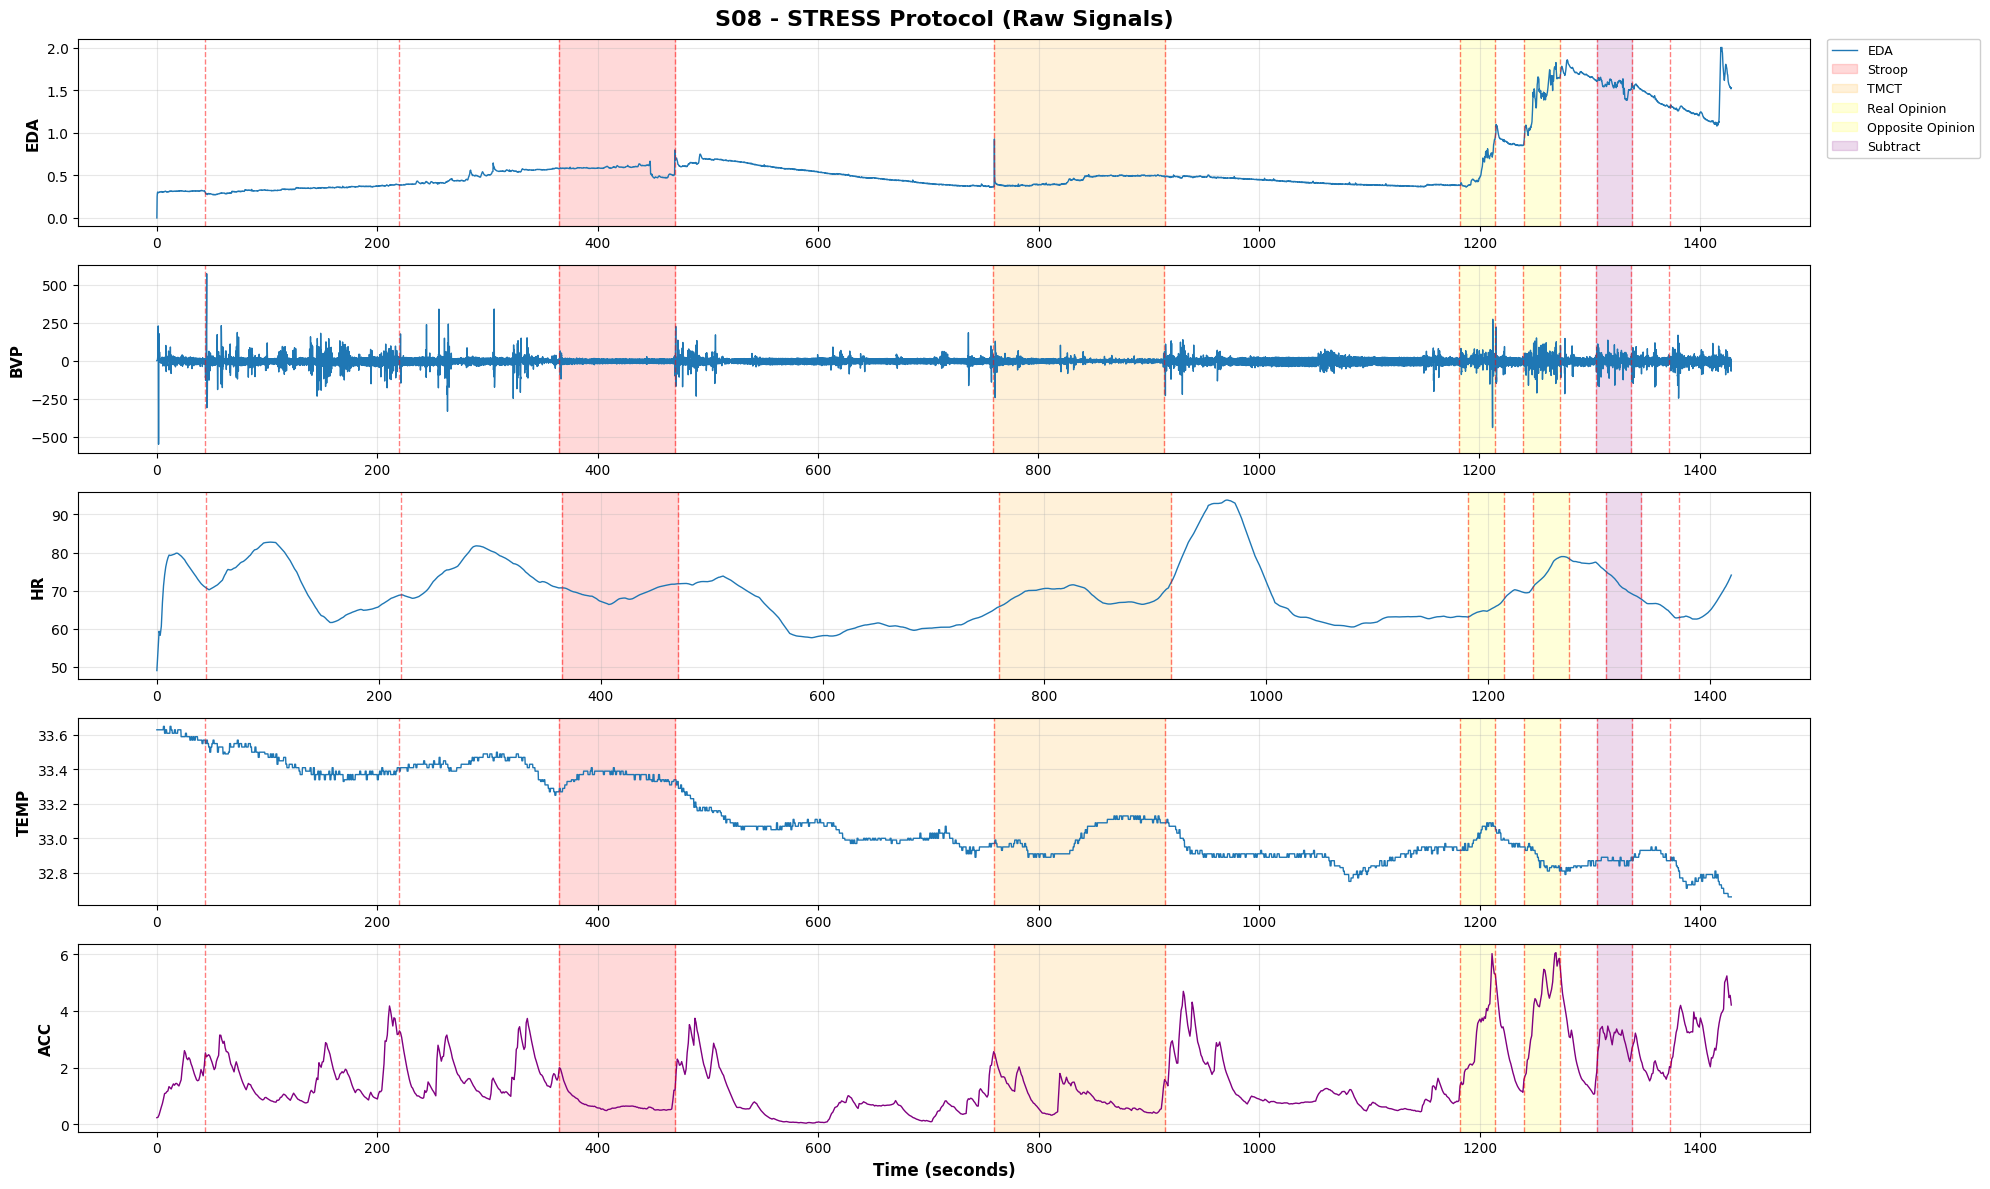

In [ ]:
#specifify subject id to visualize
subject_id = 'S08'  # Options: S04, S05, S08, S09, S10, S13, S14, S15, S17, S18, f01-f13

# Plot the selected subject
if subject_id in signal_data:
    print(f"Visualizing subject: {subject_id}")
    protocol = "V1 (with Stroop test)" if subject_id.startswith('S') else "V2 (without Stroop test)"
    print(f"Protocol: {protocol}\n")
    
    plot_subject_signals(
        subject_id,
        signal_data[subject_id],
        time_data[subject_id],
        signal_data[subject_id]['tags'],
        state='STRESS'
    )
else:
    print(f"Subject '{subject_id}' not found!")
    print(f"Available subjects: {subjects}")

Protocol: V1 (with Stroop test)



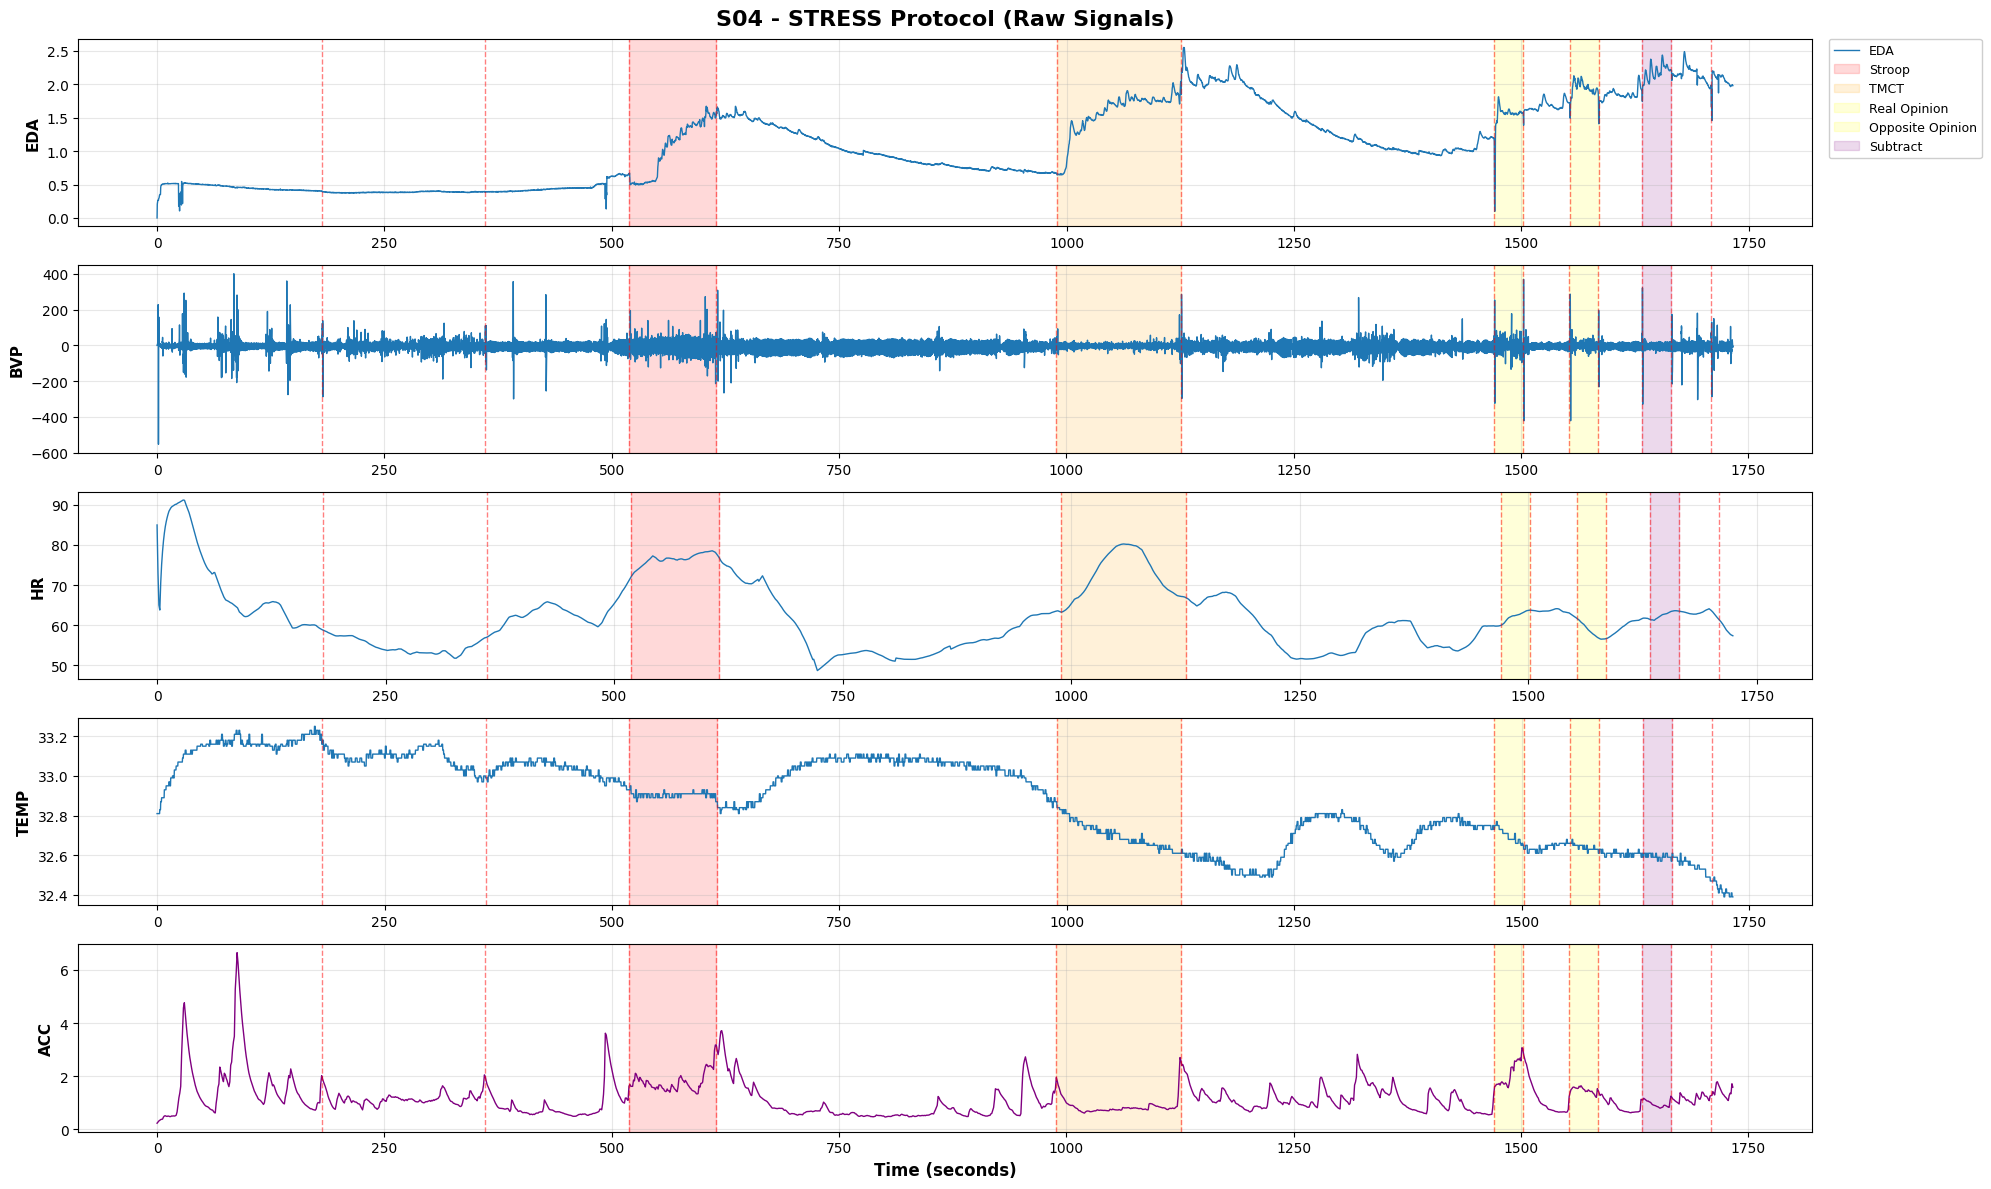

In [18]:
#PLOT FOR Subject S04
subject_S04 = 'S04'
protocol = "V1 (with Stroop test)" if subject_S04.startswith('S') else "V2 (without Stroop test)"
print(f"Protocol: {protocol}\n")

plot_subject_signals(
    subject_S04,
    signal_data[subject_S04],
    time_data[subject_S04],
    signal_data[subject_S04]['tags'],
    state='STRESS'
)

Protocol: V2 (without Stroop test)



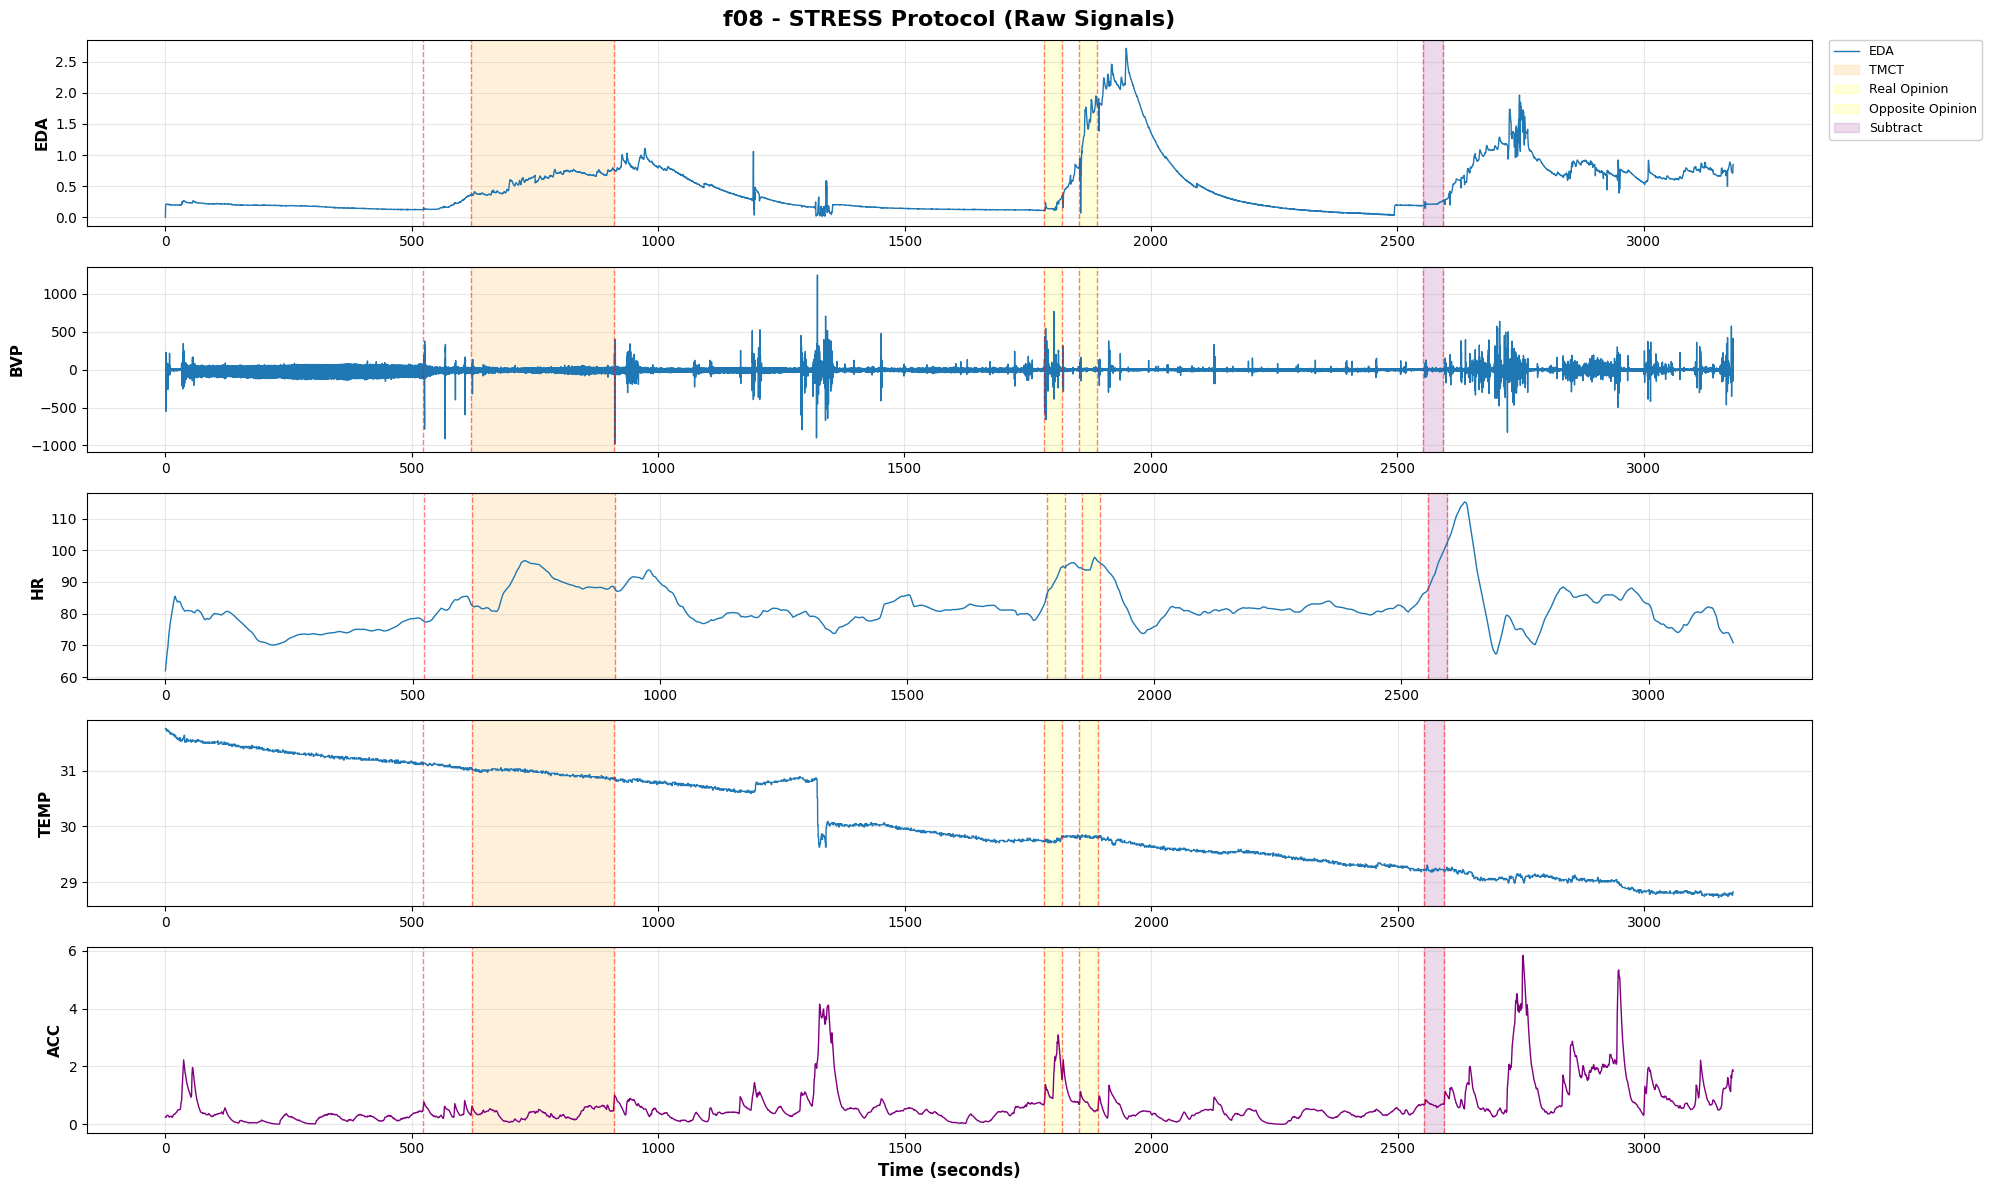

In [19]:
#PLOT FOR Subject f08 
subject_f08 = 'f08'  # or 'f03', 'S13', etc.
protocol = "V1 (with Stroop test)" if subject_f08.startswith('S') else "V2 (without Stroop test)"
print(f"Protocol: {protocol}\n")

plot_subject_signals(
    subject_f08,
    signal_data[subject_f08],
    time_data[subject_f08],
    signal_data[subject_f08]['tags'],
    state='STRESS'
)

In [ ]:
calculate_hrv(ibi_data, start_time, end_time)
Calculates Heart Rate Variability metrics:
SDNN: Standard deviation of IBI intervals (overall HRV)
RMSSD: Root mean square of successive differences (short-term HRV)
Lower HRV = Higher stress